Cristobal Gomez y Pepe López 

# Proyecto de predicción de contratación de productos para clientes de un banco

## Importe de librerias

In [440]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import numpy as np
from scoring import mapk, apk


## 1. Importación y Exploración Inicial de los Datos


### 1.1. Importación de los Datos

In [441]:

# Cargar datos
dataset = pd.read_csv('dataset_para_modelar.csv')

C:\Users\crix-\AppData\Local\Temp\ipykernel_17060\2774896306.py:2: DtypeWarning: Columns (5,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('dataset_para_modelar.csv')


### 1.2. Exploración Inicial


Mostrar información básica del dataset


In [442]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634682 entries, 0 to 634681
Data columns (total 49 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             634682 non-null  int64  
 1   cod_persona            634682 non-null  int64  
 2   mes                    634682 non-null  object 
 3   pais                   634626 non-null  object 
 4   sexo                   634617 non-null  object 
 5   edad                   634682 non-null  object 
 6   fecha1                 634626 non-null  object 
 7   xti_empleado           634626 non-null  object 
 8   xti_nuevo_cliente      634626 non-null  float64
 9   num_antiguedad         634682 non-null  object 
 10  xti_rel                634626 non-null  float64
 11  fec_ult_cli_1t         36 non-null      object 
 12  xti_rel_1mes           629040 non-null  float64
 13  tip_rel_1mes           629040 non-null  object 
 14  indresi                634626 non-nu

Descripcion de las principales metricas de cada variable

In [443]:
dataset.describe()


,Unnamed: 0,cod_persona,xti_nuevo_cliente,xti_rel,xti_rel_1mes,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25
count,634682.000000,6.346820e+05,634626.000000,634626.000000,629040.000000,634626.0,631736.000000,634626.000000,5.105180e+05,629040.000000,634682.000000,634682.0,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634651.000000,634651.000000,634682.000000,634682.000000
mean,321920.356254,7.217769e+05,0.059846,1.005559,1.000587,1.0,26.598741,0.459126,1.367071e+05,6.425623,0.000101,0.0,0.660945,0.000495,0.081740,0.009992,0.009825,0.131909,0.043504,0.002036,0.001899,0.043438,0.083139,0.018698,0.005275,0.009263,0.002718,0.053576,0.045505,0.026503,0.003756,0.055561,0.060295,0.128827,0.065876
std,185232.719038,4.290892e+05,0.237202,0.738085,0.036560,0.0,12.777667,0.498327,3.339545e+05,1.345879,0.010041,0.0,0.473389,0.022237,0.273969,0.099461,0.098635,0.338392,0.203988,0.045072,0.043531,0.203840,0.276093,0.135455,0.072438,0.095797,0.052063,0.225180,0.208408,0.160626,0.061173,0.229073,0.238032,0.335008,0.248065
min,0.000000,5.514000e+03,0.000000,1.000000,0.000000,1.0,1.000000,0.000000,4.559550e+03,0.218520,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,161691.250000,3.584120e+05,0.000000,1.000000,1.000000,1.0,15.000000,0.000000,6.821148e+04,5.117500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,322352.500000,6.230450e+05,0.000000,1.000000,1.000000,1.0,28.000000,0.000000,1.012905e+05,6.463518,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,482540.750000,1.102693e+06,0.000000,1.000000,1.000000,1.0,35.000000,1.000000,1.566742e+05,7.359949,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,641706.000000,1.537800e+06,1.000000,99.000000,4.000000,1.0,52.000000,1.000000,2.889440e+07,38.793123,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Primera visualizacion de las variables

In [444]:
dataset.head(10)

,Unnamed: 0,cod_persona,mes,pais,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25
0,0,178103,2015-01-28,ES,H,35,2015-01-12,N,0.0,6,1.0,NaN,1.0,A,S,N,KHL,N,1.0,29.0,1.0,87218.10,02 - PARTICULARES,6.134600,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
1,1,503082,2015-01-28,ES,V,27,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
2,2,502996,2015-01-28,ES,V,37,2012-08-10,N,0.0,35,1.0,NaN,1.0,A,S,N,KFC,N,1.0,8.0,0.0,104035.08,02 - PARTICULARES,6.301283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
3,3,503053,2015-01-28,ES,H,23,2012-08-10,N,0.0,35,1.0,NaN,1.0,A,S,N,KHE,N,1.0,39.0,1.0,136930.23,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0
4,4,503031,2015-01-28,ES,H,44,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0
5,5,503112,2015-01-28,ES,H,23,2012-08-10,N,0.0,35,1.0,NaN,1.0,A,S,N,KHE,N,1.0,22.0,1.0,79998.72,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
6,6,503163,2015-01-28,ES,V,22,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,50.0,0.0,59551.65,03 - UNIVERSITARIO,4.908936,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
7,7,503154,2015-01-28,ES,H,23,2012-08-10,N,0.0,35,1.0,NaN,1.0,A,S,N,KHE,N,1.0,15.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
8,8,503142,2015-01-28,ES,H,23,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,46.0,0.0,189110.64,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
9,9,502804,2015-01-28,ES,H,24,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,6.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0


## 2. Limpieza de Datos


In [445]:
dataset.columns

Index(['Unnamed: 0', 'cod_persona', 'mes', 'pais', 'sexo', 'edad', 'fecha1',
       'xti_empleado', 'xti_nuevo_cliente', 'num_antiguedad', 'xti_rel',
       'fec_ult_cli_1t', 'xti_rel_1mes', 'tip_rel_1mes', 'indresi', 'indext',
       'des_canal', 'xti_extra', 'tip_dom', 'cod_provincia',
       'xti_actividad_cliente', 'imp_renta', 'id_segmento', 'mean_engagement',
       'ind_prod1', 'ind_prod2', 'ind_prod3', 'ind_prod4', 'ind_prod5',
       'ind_prod6', 'ind_prod7', 'ind_prod8', 'ind_prod9', 'ind_prod10',
       'ind_prod11', 'ind_prod12', 'ind_prod13', 'ind_prod14', 'ind_prod15',
       'ind_prod16', 'ind_prod17', 'ind_prod18', 'ind_prod19', 'ind_prod20',
       'ind_prod21', 'ind_prod22', 'ind_prod23', 'ind_prod24', 'ind_prod25'],
      dtype='object')

### Unnamed: 0
Index

In [446]:
#Ver tipo 
print(dataset['Unnamed: 0'].dtypes)
#Recuento de clases 
print(dataset['Unnamed: 0'].value_counts())
#Recuento de nulos
print(dataset['Unnamed: 0'].isnull().sum())
#Ver distribucion
# plt.hist(dataset['Unnamed: 0']) Es un indice que no tiene distribiucion 
#Imputar nulos

int64
Unnamed: 0
0         1
429174    1
429167    1
429168    1
429169    1
         ..
215231    1
215232    1
215233    1
215235    1
641706    1
Name: count, Length: 634682, dtype: int64
0


### Cod_persona
Customer	code

In [447]:
#dataset[cod_persona]=503082 y ordenarlo por fecha1:

#Ejemplo de una persona
dataset[dataset['cod_persona']==504546].sort_values(by='fecha1') # Dataset compuesto por la evolucion de contrataciones de productos de una persona a lo largo del tiempo

,Unnamed: 0,cod_persona,mes,pais,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25
62,62,504546,2015-01-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
61530,62846,504546,2015-02-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
91495,93386,504546,2015-03-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
123869,126332,504546,2015-04-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
125782,128260,504546,2015-05-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
157209,160210,504546,2015-06-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
216829,220553,504546,2015-07-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
254727,259089,504546,2015-08-28,ES,H,24,2012-08-09,N,0.0,36,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
300440,305168,504546,2015-09-28,ES,H,24,2012-08-09,N,0.0,37,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
322426,327473,504546,2015-10-28,ES,H,24,2012-08-09,N,0.0,38,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0


In [448]:
# Agrupar por 'cod_persona' y contar el número de registros para cada persona
conteo_registros = dataset.groupby('cod_persona').size().reset_index(name='num_registros')

# Filtrar para encontrar las personas con solo un registro
personas_con_un_registro = conteo_registros[conteo_registros['num_registros'] == 1]

# Contar el número de personas con solo un registro
num_personas_con_un_registro = personas_con_un_registro.shape[0]

print(num_personas_con_un_registro)

223


Se encuentran personas con un solo registro, lo que puede ser un problema predecir un solo registro sin un historico de contrataciones. No se eliminan los registros, ya que se considera que a pesar de tener un solo registro ese estado puede contener variables muy indicativas de compras de un producto nuevo la siguiente mensualidad.

In [449]:
# Verificar si hay valores nulos en 'cod_persona'
print(dataset['cod_persona'].isnull().sum())

0


### mes
The	table	is	partitioned	for	this	column

In [450]:
# Paso la columna 'mes' a datetime
dataset['mes'] = pd.to_datetime(dataset['mes'], format='%Y-%m-%d')
#Recuento de nulos:
print(dataset['mes'].isnull().sum())

0


In [451]:
#Extraemos las caracteristicas de mes, dia y año:
dataset['mes_mes']=dataset['mes'].dt.month
dataset['mes_año']=dataset['mes'].dt.year

In [452]:
#Se estudia el numero de registros por mes y año para ver el balanceo de clases:
print(dataset.groupby(['mes_mes', 'mes_año']).size())

mes_mes  mes_año
1        2015       30849
         2016       45994
2        2015       30988
         2016       46287
3        2015       31138
         2016       46549
4        2015       31250
         2016       46776
5        2015       31336
6        2015       31429
7        2015       41342
8        2015       42016
9        2015       43170
10       2015       44574
11       2015       45309
12       2015       45675
dtype: int64


Se observa que el dataset esta balanceado en cuanto a la cantidad de registros por mes y año.
Se observa que el historico acaba en abril de 2016.

### pais
Customer's	Country	residence

In [453]:
print(dataset['pais'].value_counts())


pais
ES    631736
DE       285
GB       244
FR       224
US       203
CH       192
CO       160
AR       144
IT       138
MX       122
RO       104
EC        90
VE        80
CL        74
PY        74
BE        64
BR        52
AT        48
CA        48
FI        32
NL        32
PL        32
CN        32
PE        32
BG        32
BO        26
GT        16
PK        16
PT        16
GN        16
PR        16
JP        16
IL        16
SA        16
NG        16
NZ        16
IN        16
AD        16
UA        16
SE        16
GE        16
CU        16
PA        16
SV        16
AU        11
MD        10
RU        10
HU         7
Name: count, dtype: int64


Se observa como la mayoría de los registros son de España, resultando el resto de paises en cifras no significativas. Se podría considerar la posibilidad de agrupar los paises con menos registros en un grupo llamado "Otros" para reducir la dimensionalidad de la variable y se mapea a 0-1. 

In [454]:
# Crear un diccionario de mapeo para agrupar los países
#Si pais es España el valor de la columna pais_es será 1, sino 0:
dataset['pais_binario'] = dataset['pais'].apply(lambda x: 1 if x == 'ES' else 0)
dataset.drop(columns=['pais'], inplace=True)
dataset['pais_binario'].value_counts()

pais_binario
1    631736
0      2946
Name: count, dtype: int64

In [455]:
dataset['pais_binario'].isnull().sum() #No hay valores nulos

0

### sexo
Customer's	sex

In [456]:
dataset['sexo'].isnull().sum()

65

In [457]:
dataset[dataset['cod_persona']==170635]

,Unnamed: 0,cod_persona,mes,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,pais_binario
51501,52614,170635,2015-02-28,NaN,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2015,0
82415,84130,170635,2015-03-28,NaN,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2015,0
113518,115788,170635,2015-04-28,NaN,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2015,0
134835,137477,170635,2015-05-28,NaN,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015,0
165637,168754,170635,2015-06-28,NaN,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,6,2015,0
463976,470442,170635,2016-01-28,V,40,2015-02-17,N,1.0,0,1.0,NaN,3.0,P,S,N,NaN,N,1.0,29.0,0.0,NaN,NaN,19.192186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2016,1
506018,512718,170635,2016-02-28,V,40,2015-02-17,N,1.0,1,1.0,NaN,1.0,A,S,N,KHM,N,1.0,7.0,0.0,NaN,02 - PARTICULARES,6.543075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2016,1
550982,557823,170635,2016-03-28,V,40,2015-02-17,N,1.0,2,1.0,NaN,1.0,I,S,N,KHM,N,1.0,7.0,0.0,NaN,02 - PARTICULARES,6.543075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2016,1
623367,630379,170635,2016-04-28,V,40,2015-02-17,N,1.0,3,1.0,NaN,1.0,I,S,N,KHM,N,1.0,7.0,0.0,NaN,02 - PARTICULARES,6.543075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2016,1


Se observan que hay valores nulos en la columna 'sexo' que no en todos los registros de la misma persona son nulos. Suponiendo que el sexo de una persona no puede cambiar en el tiempo, se decide rellenar los valores nulos con el valor que tiene para otros registros.

In [458]:
# Calcular el número de registros por 'cod_persona'
num_registros_por_persona = dataset.groupby('cod_persona').size().reset_index(name='total_registros')

# Calcular el número de valores nulos en la columna 'sexo' por cada 'cod_persona'
num_nulos_por_persona = dataset.groupby('cod_persona')['sexo'].apply(lambda x: x.isnull().sum()).reset_index(name='num_nulos')

# Unir la información de los nulos y el total de registros al dataset original
info_completa = num_registros_por_persona.merge(num_nulos_por_persona, on='cod_persona')

# Filtrar para encontrar las personas donde el número de nulos es igual al número de registros
personas_con_todos_nulos = info_completa[info_completa['total_registros'] == info_completa['num_nulos']]

print(personas_con_todos_nulos)

       cod_persona  total_registros  num_nulos
41790      1337182                9          9


La unica persona con todos los valores de sexo nulos es la persona 41790. Se decide rellenar los valores de esta persona como si fuera un hombre, son solo 9 registros por lo que no afecta a la distribución de la variable. 

In [459]:
dataset.loc[dataset['cod_persona'] == 1337182, 'sexo'] = dataset.loc[dataset['cod_persona'] == 1337182, 'sexo'].fillna('V')

Rellenamos todos los valores nulos de cada persona con otro valor del campo sexo que ya exista para ese cod_persona

In [460]:
valores_no_nulos = dataset.dropna(subset=['sexo']).drop_duplicates(subset=['cod_persona'], keep='first')
# Crear un diccionario con los valores no nulos
valores_no_nulos_dict = valores_no_nulos.set_index('cod_persona')['sexo'].to_dict()

#Rellenar los valores nulos en 'sexo' usando el valor no nulo correspondiente de cada 'cod_persona'
dataset['sexo'] = dataset.apply(lambda row: valores_no_nulos_dict.get(row['cod_persona'], row['sexo']) if pd.isnull(row['sexo']) else row['sexo'], axis=1)


In [461]:
# Crear un diccionario de mapeo para asignar números a cada género
mapping_sex = {'V': 1, 'H': 0}

# Aplicar el mapeo a la columna 'customer_sex'
dataset['sexo'] = dataset['sexo'].map(mapping_sex)

In [462]:
dataset['sexo'].value_counts()


sexo
1    346889
0    287793
Name: count, dtype: int64

### edad
Customer’s	age

In [489]:
dataset['edad'].isnull().sum()

0

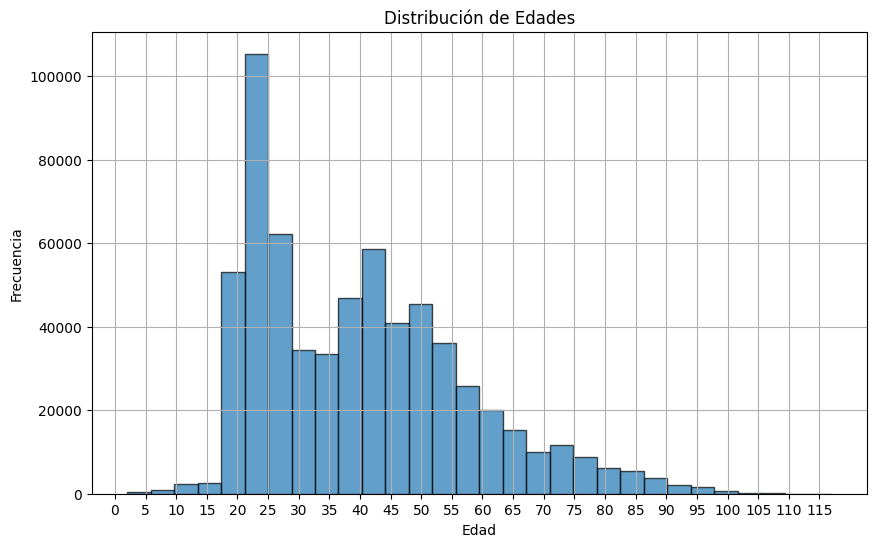

In [410]:
dataset['edad'] = pd.to_numeric(dataset['edad'], errors='coerce')

# Plottear la distribución de edades
plt.figure(figsize=(10, 6))
plt.hist(dataset['edad'].dropna(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribución de Edades')
plt.xticks(range(0, 120, 5))
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Se observa que la distribución es bastante uniforme sin un skewness claramente definido. Sin embargo, se destaca como entre los 20-25 años hay un pico de personas.

### fecha1
The	date	in	which	the	customer	became	as	the	first	holder	of	a	contract	in	the	bank

In [439]:
dataset['fecha1'].isnull().sum()

56

Se observa que hay 56 valores nuloes en varias columnas. Se buscan patrones e intentamos adoptar el mismo enfoque con ellas:

In [469]:
print(dataset.isnull().sum()==56)

Unnamed: 0               False
cod_persona              False
mes                      False
sexo                     False
edad                     False
fecha1                    True
xti_empleado              True
xti_nuevo_cliente         True
num_antiguedad           False
xti_rel                   True
fec_ult_cli_1t           False
xti_rel_1mes             False
tip_rel_1mes             False
indresi                   True
indext                    True
des_canal                False
xti_extra                 True
tip_dom                   True
cod_provincia            False
xti_actividad_cliente     True
imp_renta                False
id_segmento              False
mean_engagement          False
ind_prod1                False
ind_prod2                False
ind_prod3                False
ind_prod4                False
ind_prod5                False
ind_prod6                False
ind_prod7                False
ind_prod8                False
ind_prod9                False
ind_prod

In [475]:
dataset[dataset['fecha1'].isnull()]

,Unnamed: 0,cod_persona,mes,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año,pais_binario
1453,1471,532938,2015-01-28,1,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0,0,1,2015,0
2570,2604,421992,2015-01-28,0,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,0,0,1,2015,0
5323,5421,672042,2015-01-28,0,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0
7976,8123,256163,2015-01-28,0,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,1,2015,0
8899,9085,289373,2015-01-28,1,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,1,2015,0
9160,9358,300713,2015-01-28,1,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0
10037,10262,210920,2015-01-28,0,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0
10178,10408,205901,2015-01-28,0,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,1,2015,0
10287,10523,183684,2015-01-28,0,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,1,2015,0
11391,11674,216184,2015-01-28,0,NA,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015,0


Todas las columnas son NaN, se dropean todos los registros

In [499]:
#Dropeamos los registros con valores nulos
dataset.dropna(subset=['fecha1'], inplace=True)

#### Ind_proc23 y Ind_prod22

In [259]:
dataset[['ind_prod23', 'ind_prod22']].astype('Int64')


,ind_prod23,ind_prod22
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
634677,0,0
634678,0,0
634679,0,0
634680,0,0


#### xti_extra

In [260]:
print(dataset['xti_extra'].value_counts()) #Casi todas las personas se consideran que estan vivas por lo que no aporta informacion y decide borrarse a las muertas
print(dataset['xti_extra'].isnull().sum()) #56 valores nulos.

xti_extra
N    633108
S      1518
Name: count, dtype: int64
56


In [261]:
print(dataset['tip_dom'].value_counts()) #Todas las personas tienen un domicilio particular por lo que no aporta informacion

tip_dom
1.0    634626
Name: count, dtype: int64


In [262]:
print(dataset['Unnamed: 0'].value_counts()) # No aporta información por lo que son las filas que se han añadido al cargar el dataset

Unnamed: 0
0         1
429174    1
429167    1
429168    1
429169    1
         ..
215231    1
215232    1
215233    1
215235    1
641706    1
Name: count, Length: 634682, dtype: int64


In [263]:

# Eliminar columnas innecesarias
columns_to_drop = ['Unnamed: 0', 'xti_extra', 'tip_dom']

# Unnamed la elimino porque es un índice que se ha guardado en el csv
# xti_extra la elimino porque es una variable que no aporta información ya que la mayoría de los registros son personas vivas
# tip_dom la elimino porque es una variable que no aporta información ya que no aporta informacion, todas son 1

dataset.drop(columns=columns_to_drop, inplace=True)


In [264]:
dataset['pais'].value_counts()


KeyError: 'pais'

Se observa como la mayoría de los registros son de España, resultando el resto de paises en cifras no significativas. Se podría considerar la posibilidad de agrupar los paises con menos registros en un grupo llamado "Otros" para reducir la dimensionalidad de la variable y se mapea a 0-1. 

In [ ]:
# Crear un diccionario de mapeo para asignar números a cada género
mapping_sex = {'V': 1, 'H': 0}

# Aplicar el mapeo a la columna 'customer_sex'
dataset['sexo'] = dataset['sexo'].map(mapping_sex)

In [ ]:
dataset['sexo'].value_counts()


In [ ]:
dataset['imp_renta'].max()

In [ ]:
dataset['imp_renta'].hist()
plt.title('Distribución de imp_renta')
plt.xlabel('Ingresos Brutos (imp_renta)')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Filtrar los valores extremos
q_low = dataset['imp_renta'].quantile(0.01)
q_high = dataset['imp_renta'].quantile(0.99)
filtered_data = dataset[(dataset['imp_renta'] >= q_low) & (dataset['imp_renta'] <= q_high)]

# Crear el histograma con los datos filtrados
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['imp_renta'], color='blue', edgecolor='black')
plt.title('Distribución de imp_renta (valores filtrados)')
plt.xlabel('Ingresos Brutos (imp_renta)')
plt.ylabel('Frecuencia')
plt.show()

Es una distribución completamente sesgada (right-skewed) donde los valores se concentran en la parte baja de la distribución.
Podríamos considerar la posibilidad de aplicar una transformación logarítmica para reducir el sesgo y mejorar la distribución de los datos.

In [ ]:
#Recuento de nulos por columna:
dataset.isnull().sum().sort_values(ascending=False)

In [ ]:
##Notificamos que fec_ult_cli_1t tiene casi el 100% de los valores nulos, por lo que se elimina
dataset.drop(columns=['fec_ult_cli_1t'], inplace=True)

### xti_rel

In [ ]:
dataset['xti_rel'] = pd.to_numeric(dataset['xti_rel'], errors='coerce')
dataset['xti_rel'].value_counts()


In [ ]:
dataset['xti_rel'].fillna(1, inplace=True)

In [ ]:
dataset['xti_rel'] = dataset['xti_rel'].apply(lambda x: 1 if x == 1 else 0)
dataset['xti_rel'].value_counts()

### xti_rel_1mes

In [ ]:
dataset['xti_rel_1mes'] = pd.to_numeric(dataset['xti_rel_1mes'], errors='coerce')


In [ ]:
dataset['xti_rel_1mes'].value_counts()

In [ ]:
dataset['xti_rel_1mes'] = dataset['xti_rel_1mes'].apply(lambda x: 1 if x == 1 else 0)
dataset['xti_rel_1mes'].value_counts()

Casi todos los valores son 1. 

## mean_engagement, tip_rel_1mes, 

In [ ]:
dataset['mean_engagement'].value_counts()


In [ ]:
dataset['tip_rel_1mes'].value_counts()


### xti_empleado
lo consideramos como una variable binaria porque casi todos los valores se concentran en N

In [ ]:
dataset['xti_empleado'].value_counts()


In [ ]:
dataset['xti_empleado'] = dataset['xti_empleado'].apply(lambda x: 1 if x == 'N' else 0)
dataset['xti_empleado'].value_counts()

### num_antiguedad
Comprobamos la variable num_antiguedad: 

In [ ]:
dataset['num_antiguedad'] = pd.to_numeric(dataset['num_antiguedad'], errors='coerce')


In [ ]:
plt.figure(figsize=(10, 6))  # Create a figure with desired size
plt.hist(dataset['num_antiguedad'], bins=10, color='blue', edgecolor='black')  

plt.title('Distribución de antiguedad (valores filtrados)')  
plt.xlabel('Meses de antiguedad')  
plt.ylabel('Frecuencia')  

plt.show()  

In [ ]:
pd.set_option('display.max_columns', None)
print(dataset.head(5))

Calcular los valores de la moda y la mediana


ESTO ES MIERDA! NO FUNCIONA

In [ ]:
most_frequent_xti_rel_1mes = dataset['xti_rel_1mes'].mode()[0]
most_frequent_tip_rel_1mes = dataset['tip_rel_1mes'].mode()[0]
median_engagement_score = dataset['mean_engagement'].median()

Rellenar valores nulos con los valores calculados


In [ ]:
dataset['xti_rel_1mes'].fillna(most_frequent_xti_rel_1mes, inplace=True)
dataset['tip_rel_1mes'].fillna(most_frequent_tip_rel_1mes, inplace=True)
dataset['mean_engagement'].fillna(median_engagement_score, inplace=True)

Reemplazar valores nulos en cod_provincia por 0


In [ ]:
dataset['cod_provincia'].fillna(0, inplace=True)


Convertir las provincias categóricas a números


In [ ]:
dataset['cod_provincia'] = dataset['cod_provincia'].astype('category').cat.codes

In [ ]:
# Limpiar datos
dataset['edad'].fillna(dataset['edad'].mean(), inplace=True)
#Rellenamos con la media porque se considera mas representativa 
# dataset['imp_renta'].fillna(dataset['imp_renta'].median(), inplace=True) 
#Rellenamos con mediana porque existen outliers muy elevados que sesgarian el valor si rellenamos con la media los valores faltantes 

"""
Se añade el codigo para una visualizacion de la distribución logaritmica por si quisiera visualizarse
"""
# transformed_data = np.log1p(dataset['imp_renta'])  # log1p aplica log(1 + x) para manejar valores de 0
# plt.hist(transformed_data)
# plt.title('Distribución transformada de imp_renta (log)')
# plt.xlabel('Log(imp_renta)')
# plt.ylabel('Frecuencia')
# plt.show()

In [ ]:
# Feature Engineering
dataset['nueva_caracteristica'] = dataset['edad'] * dataset['imp_renta']

# Verificar cambios
print(dataset.head())

In [ ]:
# Convertir columnas con valores mixtos a numéricos
dataset['num_antiguedad'] = pd.to_numeric(dataset['num_antiguedad'], errors='coerce')
dataset['num_antiguedad'].fillna(dataset['num_antiguedad'].mean(), inplace=True)
dataset['xti_rel_1mes'] = pd.to_numeric(dataset['xti_rel_1mes'], errors='coerce')
dataset['xti_rel_1mes'].fillna(dataset['xti_rel_1mes'].mean(), inplace=True)

# Convertir columnas categóricas en variables dummy
categorical_columns = ['pais', 'sexo', 'xti_empleado', 'xti_rel', 'indresi', 'indext', 'des_canal', 'xti_extra', 'tip_rel_1mes']
dataset = pd.get_dummies(dataset, columns=categorical_columns)



dataset.columns

In [ ]:

# Verificar los cambios
print(dataset.info())
print(dataset.head())

# Separar características y targets
X = dataset.drop(columns=[f'ind_prod{i}' for i in range(1, 26)])
y = dataset[[f'ind_prod{i}' for i in range(1, 26)]]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# Entrenar el modelo
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)

# Generar predicciones
predicciones = modelo.predict(X_test)

# Convertir predicciones y valores reales a listas de listas para MAP@7
y_test_list = [list(np.where(row == 1)[0] + 1) for row in y_test.values]
predicciones_list = [list(np.argsort(row)[-7:][::-1] + 1) for row in predicciones]

# Calcular MAP@7
score = mapk(y_test_list, predicciones_list, 7)
print(f'MAP@7 Score: {score}')